## 0. Boas práticas

#### Boas práticas aplicadas:
        - A versão só é finalizada com códigos comentados
        - Operação no ambiente vistual definido
        - Commit diário no git, independente de atualização finalizada.


#### O ambiente de trabalho usado foi o aneel_energisa_3.8:
        - Algumas bibliotecas não estavam atualizadas para py3.9
        - Requirements.txt atualizados diariamenteapós cada etapa do projeto


#### Commit no git
        - Commit diário e comentado da pasta


## 1. ETL 
#### (extração de dados)


In [5]:
# Bibliotecas - API
import requests

# Bibliotecas - Gráficos
import numpy as np
import pandas as pd
import missingno as msno
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

# Bibliotecas - Dash
import dash
from dash import dcc
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

# Outras
import warnings
warnings.filterwarnings('ignore')


#_________________________Cria a url de requisição da API_Aneel______________________________#
# https://dadosabertos.aneel.gov.br/dataset/relacao-de-empreendimentos-de-geracao-distribuida



# A api não pediu autenticação, para replicações futuras observar
# API Keys
# OAuth: aplicação de terceiros sem login
# Token: autenticação de usuários
# Certificados



# definições na criação do URL
url_base = "https://dadosabertos.aneel.gov.br/api/action/datastore_search?"
resource_id="b1bd71e7-d0ad-4214-9053-cbd58e9564a7"
limit_param = 1000000
timeout_seconds = 100
# offset: É útil para obter grandes conjuntos de dados em lotes menores
# sort: especifica em que ordem os resultados devem ser retornados (ascendente/descendente)
# q: restringe a requisicap à palavras chaves
# filters: filtra valores com base em falores por multiplas colunas
# fields: especifica os campos da tabela
# groups: agrupa os resultados por campos




def criar_url(resource_id, limit):
    resource_param = "resource_id=" + resource_id
    limit_param = "limit=" + str(limit)

    url = url_base + resource_param + "&" + limit_param
    return url
url = criar_url(resource_id, limit_param)

# Obter os dados da API
def get_data(url, timeout_seconds):
    try:
        # Requisição GET com o tempo limite definido
        response = requests.get(url, timeout=timeout_seconds)

        #  Verifica erros HTTP
        response.raise_for_status()

    except requests.exceptions.RequestException as e:
        print("Erro ao obter os dados:", e)
        return None

    # Resposta HTTP=200, indicando que a requisição foi bem sucedida
    if response.status_code == 200:
        # Em caso de sucesso, obtenha os dados em formato JSON e imprima "Requisição bem sucedida"
        data = response.json()
        print("Requisição bem sucedida")

        # Verificar resposta da API
        if data["success"]:
            # Gera lista de registros e a lista de colunas
            records = data["result"]["records"]
            columns = data["result"]["fields"]

            # Alguns dados não estavam presentes na tabela, realizei um teste de captação para as colunas "Bandeira" e "Nome_agente" na lista de colunas
            columns.append({"id": "Bandeira", "type": "text"})
            columns.append({"id": "Nome_agente", "type": "text"})

            # Cria o DataFrame
            df = pd.DataFrame.from_records(records, columns=[c["id"] for c in columns])

            # Retorne o DataFrame criado
            return df
        
            # Em caso de sucesso sem terotno de dados
        else:
            # Em caso de erro, imprir uma mensagem de aviso e retorne None
            print("A API não retornou dados.")
            return None
            
            # Se o código de status da resposta HTTP for diferente de 200, trate o erro de acordo com o código
    else:
        if response.status_code == 400:
            print("Requisição mal formada.")
        elif response.status_code == 401:
            print("Não autorizado.")
        elif response.status_code == 403:
            print("Acesso proibido.")
        elif response.status_code == 404:
            print("Recurso não encontrado.") 
        elif response.status_code == 500:
            print("Erro interno do servidor.")
        else:
            print("Erro desconhecido ao obter os dados.")

        return None

# Chame a função get_data para obter um DataFrame com os dados da API
df = get_data(url, timeout_seconds)

Requisição bem sucedida


## 2. EDA
#### (estudo dos dados)

### 2.1 - Tratamento de dados


 #### Análises realizadas : verificações obtidas
    - Formato de dados: inicialmente, algumas colunas do DataFrame possuíam valores do tipo 'object', que foram atualizados para as classes corretas (e.g. 'datetime', 'float', 'int').
    - Análise de valores vazios: não foi identificado um padrão de valores vazios no DataFrame, porém isso não deve ser um problema, uma vez que não pretendemos utilizá-los.
    - Análise de valores nulos: também não foi identificado um padrão de valores nulos no DataFrame, o que não deve ser um problema para nossas análises.
    - Análise de valores duplicados: felizmente, não encontramos valores duplicados no DataFrame, o que é sempre um bom sinal.

In [15]:
import matplotlib.pyplot as plt
import missingno as msno

# Atualizando formato de colunas
def atualiza_formato_colunas(df):
    df = df.astype({
        "NumCNPJDistribuidora": np.int64,
        "CodClasseConsumo": np.int64,
        "CodSubGrupoTarifario": np.int64,
        "codUFibge": np.float64,
        "codRegiao": np.float64,
        "CodMunicipioIbge": np.float64,
        "QtdUCRecebeCredito": np.int64,
    })
    return df
df = atualiza_formato_colunas(df)

# análise de vazios
def analyze_dataframe(df):
    # Análise de colunas duplicadas
    duplicated_cols = df.columns[df.columns.duplicated(keep=False)]
    df_duplicated_col = df[duplicated_cols].sum()
    print('Colunas duplicadas: ', df_duplicated_col.tolist())

    # Análise de linhas duplicadas
    duplicated_rows = df.duplicated(keep=False)
    df_duplicated_line = duplicated_rows.sum()
    print('Linhas duplicadas: ', df_duplicated_line.tolist())

    # Análise de valores nulos
    na_tot = df.isna().sum().sort_values(ascending=False)
    na_perc = (df.isna().sum() / df.shape[0] * 100).round(2).sort_values(ascending=False)
    na = pd.concat([na_tot, na_perc], axis=1, keys=['+', '%'])
    print(na.head(10))
analyze_dataframe(df)

def check_duplicates(df):
    # Verifica colunas duplicadas
    duplicated_cols = df.columns[df.columns.duplicated(keep=False)]
    num_duplicated_cols = len(duplicated_cols)
    
    # Verifica linhas duplicadas
    duplicated_rows = df.duplicated(keep=False)
    num_duplicated_rows = duplicated_rows.sum()
    
    # Retorna o resultado
    return num_duplicated_cols, num_duplicated_rows
check_duplicates(df)


def visualizar_nulos(df):
    sorted_df = df.sort_values(by='NumCoordEEmpreendimento')
    fig, ax = plt.subplots(figsize=(10, 6))

    # Cria a matriz de visualização de nulos com o eixo x em rotação vertical e tamanho de fonte menor
    matriz_nulos = msno.matrix(sorted_df, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
    plt.show()
#visualizar_nulos(df)


# Adicionando as colunas Ano, Mes e Ano_Mes
def adiciona_colunas(df):
    df['DatetimeIndex'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend'])
    df['Mes'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).month
    df['Ano'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).year
    df['Ano_Mes'] = pd.to_datetime(df['DthAtualizaCadastralEmpreend']).dt.strftime('%Y-%m')
    return df
adiciona_colunas(df)

df_clean = df.dropna(subset=['NumCPFCNPJ']).copy()


Colunas duplicadas:  []
Linhas duplicadas:  0
                             +       %
Nome_agente              32000  100.00
Bandeira                 32000  100.00
NumCoordNSub             31965   99.89
NumCoordESub             31965   99.89
NomSubEstacao            31965   99.89
NumCoordNEmpreendimento  27814   86.92
NumCoordEEmpreendimento  27814   86.92
codRegiao                   49    0.15
codUFibge                   49    0.15
CodEmpreendimento            2    0.01


,_id,DatGeracaoConjuntoDados,AnmPeriodoReferencia,NumCNPJDistribuidora,SigAgente,NomAgente,CodClasseConsumo,DscClasseConsumo,CodSubGrupoTarifario,DscSubGrupoTarifario,...,NumCoordEEmpreendimento,NomSubEstacao,NumCoordESub,NumCoordNSub,Bandeira,Nome_agente,DatetimeIndex,Mes,Ano,Ano_Mes
0,1,2023-03-31,03/2023,33050196000188,CPFL-PAULISTA,COMPANHIA PAULISTA DE FORÇA E LUZ,1,Residencial,9,B1,...,None,None,None,None,NaN,NaN,2023-01-23,1,2023,2023-01
1,2,2023-03-31,03/2023,4895728000180,Equatorial PA,EQUATORIAL PARÁ DISTRIBUIDORA DE ENERGIA S.A.,1,Residencial,9,B1,...,None,None,None,None,NaN,NaN,2023-02-17,2,2023,2023-02
2,3,2023-03-31,03/2023,4065033000170,ELETROACRE,ENERGISA ACRE - DISTRIBUIDORA DE ENERGIA S.A,2,Comercial,11,B3,...,"-9,96",None,None,None,NaN,NaN,2015-07-15,7,2015,2015-07
3,4,2023-03-31,03/2023,4065033000170,ELETROACRE,ENERGISA ACRE - DISTRIBUIDORA DE ENERGIA S.A,1,Residencial,9,B1,...,"-8,15",None,None,None,NaN,NaN,2015-04-20,4,2015,2015-04
4,5,2023-03-31,03/2023,4065033000170,ELETROACRE,ENERGISA ACRE - DISTRIBUIDORA DE ENERGIA S.A,2,Comercial,11,B3,...,None,None,None,None,NaN,NaN,2015-06-22,6,2015,2015-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,31996,2023-03-31,03/2023,15139629000194,COELBA,COMPANHIA DE ELETRICIDADE DO ESTADO DA BAHIA C...,3,Rural,10,B2,...,"-12,90",RODA VELHA,"-45,94","-12,75",NaN,NaN,2018-01-16,1,2018,2018-01
31996,31997,2023-03-31,03/2023,15139629000194,COELBA,COMPANHIA DE ELETRICIDADE DO ESTADO DA BAHIA C...,3,Rural,10,B2,...,None,None,None,None,NaN,NaN,2018-01-12,1,2018,2018-01
31997,31998,2023-03-31,03/2023,15139629000194,COELBA,COMPANHIA DE ELETRICIDADE DO ESTADO DA BAHIA C...,2,Comercial,11,B3,...,None,None,None,None,NaN,NaN,2019-12-09,12,2019,2019-12
31998,31999,2023-03-31,03/2023,15139629000194,COELBA,COMPANHIA DE ELETRICIDADE DO ESTADO DA BAHIA C...,1,Residencial,9,B1,...,None,None,None,None,NaN,NaN,2018-01-19,1,2018,2018-01


### 2.2 - Estudando os dados - novos usuários

##### Objetivo principal: Estudar a serie temporal de novos usuários nos fatores
        - Conhecer os dados (tendências, sazonalidades, resíduos, autocorrelações, distribuição e outliers)
        - Definir os objetivos da previsão (interpretabilidade, simplicidade, escalabilidade, robustez)
        - Teste e validação
        -

        

##### Resultados obtidos com o estudo dos dados
 - Tendencia: ascendente nos últimos 3 anos com crescimento acelerado em 2022 e queda em 2023
 - Sazonalidade: não há sazonalidade significativa nos dados, ou seja, não há padrões claros de repetição ao longo do tempo.
 - Resíduo: O gráfico não apresentou padrões significativos, mostrando algum nível de confiabilidade
 - Estacionariedade ADF: não podemos afirmar com certeza se a série é estacionária pois p valor p é 0.495 (49,5% de prob. serie ser estacionária)
 - Estacionariedade kpss: NÃO ESTACIONÁRIA, KPSS = 5,67, o que é maior que o valor crítico de 1% (0,74)
 - Autocorrelação:
 - Autocorrelação parcial: 
 - Distribuição:
 - Outliers:

#### 2.2.1 - Organizando dfs p/ estudo (*ts*)

In [38]:
# Para não causar conflitos nos dados, criatemos df específicos para cada análise oriundos de simplificações de df


df_clean = df.dropna(subset=['NumCPFCNPJ']).copy()

# estudos da serie temporal
ts = df_clean.groupby(['Ano_Mes', 'SigUF','SigTipoConsumidor', 'DscClasseConsumo']).agg({'NumCPFCNPJ': 'nunique'}).reset_index()
ts = ts.sort_values('Ano_Mes')
ts = ts.set_index('Ano_Mes')
ts_clean = ts.drop(['SigUF', 'SigTipoConsumidor','DscClasseConsumo'], axis=1)
ts_clean = ts_clean.groupby('Ano_Mes').sum()


#### 2.2.2 Análises iniciais (Tendencia, estacionariedade, sazonalidade, residuo )

In [11]:
import statsmodels.api
from statsmodels.tsa.seasonal import seasonal_decompose
resultado = seasonal_decompose(ts_clean['NumCPFCNPJ'], period = 12)

tendencia = resultado.trend
sazonalidade = resultado.seasonal
residuo = resultado.resid

#### 2.2.3 Visualização gerao de novos usuários da rede por dia

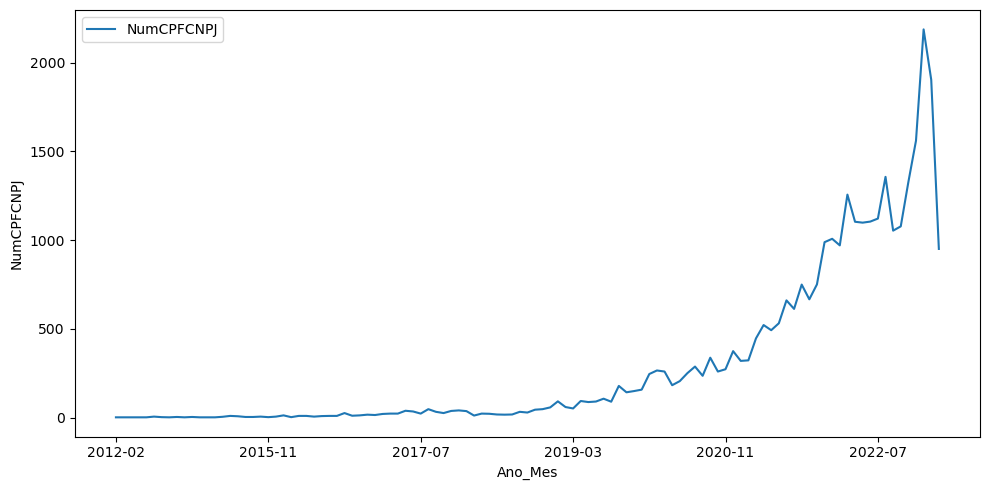

In [21]:
ts_clean.plot(figsize=(10, 5))
plt.xlabel('Ano_Mes')
plt.ylabel('NumCPFCNPJ')
plt.tight_layout()

#### 2.2.4 - tendencia

In [30]:
ts_clean

,NumCPFCNPJ
Ano_Mes,
2012-02,1
2013-10,1
2014-02,1
2014-03,1
2014-06,1
...,...
2022-11,1327
2022-12,1560
2023-01,2187


In [29]:
#tend, ax = plt.subplots(figsize=(10, 5))
#ax.plot(tendencia)
#ax.set_xlabel('Ano_Mes')
#ax.set_xticks(range(0, len(ts_clean), 300))
#ax.set_ylabel('NumCPFCNPJ')
#ax.set_title('Tendência')



#______________tendencia
fig_tendencia = go.Figure()
# Adicionar linha da tendência
fig_tendencia.add_trace(go.Scatter(x=ts_clean.index, y=tendencia, mode='lines', name='Tendência'))
# Configurar o layout
fig_tendencia.update_layout(
    xaxis_title='Ano_Mes',
    yaxis_title='NumCPFCNPJ',
    title='Tendência',
    width=1200,
    height=650
)
# A tendencia de novos usuários por dia apresenta uma crescente até o fim de 2022

#### 2.2.5 - sazonalidade

Text(0.5, 1.0, 'sazonalidade')

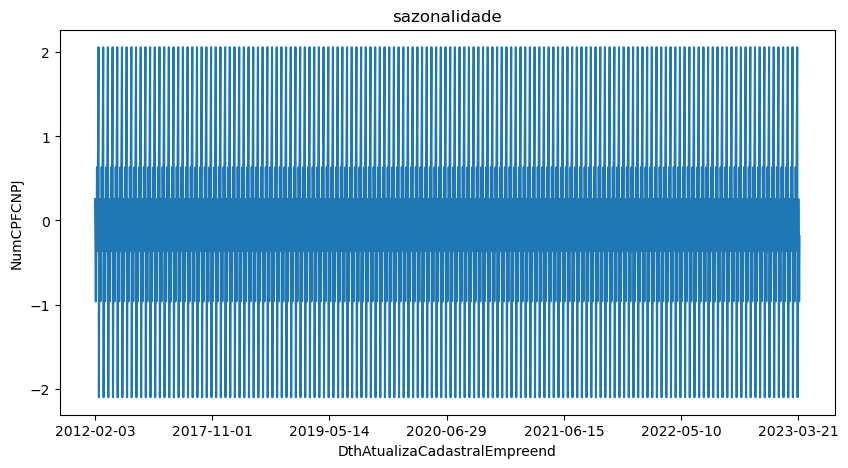

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sazonalidade)
ax.set_xlabel('DthAtualizaCadastralEmpreend')
ax.set_xticks(range(0, len(ts_clean), 300))
ax.set_ylabel('NumCPFCNPJ')
ax.set_title('sazonalidade')

# não há sazonalidade significativa nos dados, ou seja, não há padrões claros de repetição ao longo do tempo.

#### 2.2.6 - resíduo

Text(0.5, 1.0, 'residuo')

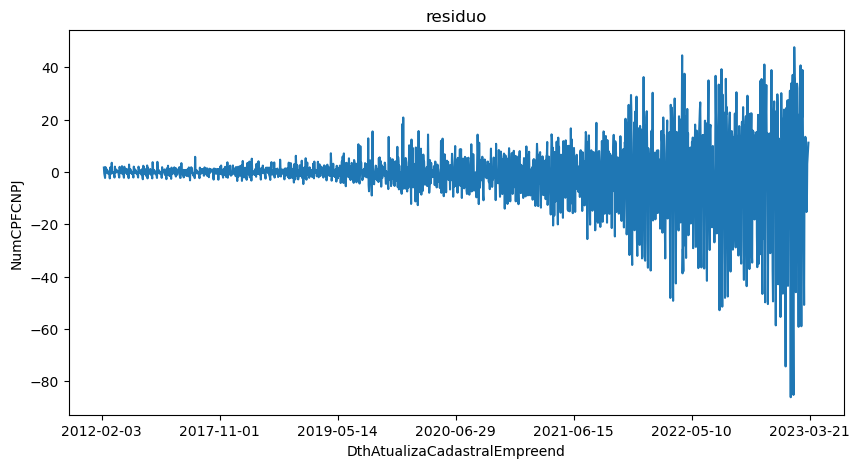

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(residuo)
ax.set_xlabel('DthAtualizaCadastralEmpreend')
ax.set_xticks(range(0, len(ts_clean), 300))
ax.set_ylabel('NumCPFCNPJ')
ax.set_title('residuo')

# O resíduo é a componente aleatória da série que não pode ser explicada pela tendência ou pela sazonalidade. O resíduo representa o erro do modelo e deve ser aleatório e não mostrar nenhum padrão discernível.
# O crescimento do resíduo pode indicar que o modelo não está capturando toda a variação nos dados ou que há algum padrão nos dados que o modelo não está conseguindo capturar1.

#### 2.2.7 - Estacionariedade

Uma série temporal é estacionária se apresenta padrão na média e na variância ao longo do tempo. 

A estacionariedade é um fundamento básico para definir o modelo a ser utilizado poismuitos assumem que a série é estacionária ou que pode ser transformada em uma série estacionária.

##### 2.2.7.1 - ADF e KPSS

ADF

        -ADF = -1.58 é um valor negativo, mas não muito negativo. Isso indica que a série é um pouco fria (um pouco estacionária), mas não o suficiente para rejeitar a hipótese nula de que a série tem uma raiz unitária (não é estacionária).
        - P = 0.495 significa que há uma probabilidade de 49,5% de obter um valor da estatística ADF igual ou mais extremo do que o observado, assumindo que a hipótese nula é verdadeira. Isso é um valor p alto, o que sugere que não há evidência suficiente para rejeitar a hipótese nula de que a série tem uma raiz unitária (não é estacionária).

KPSS

        -KPSS = 5.67. Isso é um valor muito alto, que indica que a série é muito não-estacionária. - https://en.wikipedia.org/wiki/KPSS_test
        -O valor p de 0.01 significa que há uma probabilidade de 1% de obter um valor da estatística KPSS igual ou mais extremo do que o observado

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss

# Realizando o teste ADF
resultado_adf = adfuller(ts_clean, autolag='AIC')

# criando um dicionário com os resultados obtidos
adf_dict = {'Estatística ADF': resultado_adf[0],
           'Número de atrasos': resultado_adf[2],
           'Valor p': resultado_adf[1]}
adf_dict = pd.DataFrame(adf_dict.items(), columns=['Teste', 'Resultado'])

# Imprimindo o dataframe
print('Teste ADF:')
print(adf_dict)
print()


# Realizando o teste KPSS
resultado_kpss = kpss(ts_clean, nlags='auto', regression='c')

# criando um dicionário com os resultados obtidos
kpss_dict = {'Estatística KPSS': resultado_kpss[0],
             'Número de atrasos': resultado_kpss[2],
             'Valor p': resultado_kpss[1]}

# criando um DataFrame com o dicionário
df_kpss = pd.DataFrame(kpss_dict.items(), columns=['Teste', 'Resultado'])

# imprimindo o quadro
print('Teste KPSS:')
print(df_kpss)
print()



Teste ADF:
               Teste  Resultado
0    Estatística ADF  -1.576445
1  Número de atrasos  24.000000
2            Valor p   0.495414

Teste KPSS:
               Teste  Resultado
0   Estatística KPSS   5.668923
1  Número de atrasos  25.000000
2            Valor p   0.010000



c:\Users\ghumb\anaconda\envs\aneel_energisa_3.8\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [59]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import plotly.graph_objs as go

# Realizando o teste ADF
resultado_adf = adfuller(ts_clean, autolag='AIC')
adf_dict = {'Estatística ADF': resultado_adf[0],
           'Número de atrasos': resultado_adf[2],
           'Valor p': resultado_adf[1]}
adf_dict = pd.DataFrame(adf_dict.items(), columns=['Teste', 'Resultado'])

# Realizando o teste KPSS
resultado_kpss = kpss(ts_clean, nlags='auto', regression='c')
kpss_dict = {'Estatística KPSS': resultado_kpss[0],
             'Número de atrasos': resultado_kpss[2],
             'Valor p': resultado_kpss[1]}
kpss_dict = pd.DataFrame(kpss_dict.items(), columns=['Teste', 'Resultado'])

# Criando a tabela com os resultados dos testes
fig = go.Figure(data=[go.Table(
    header=dict(values=list(['Teste', 'Resultado']),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[adf_dict['Teste'].tolist() + kpss_dict['Teste'].tolist(),
                       adf_dict['Resultado'].tolist() + kpss_dict['Resultado'].tolist()],
               fill_color='lavender',
               align='left'))
])

# Configurando o layout da tabela
fig.update_layout(title='Testes de Estacionariedade',
                  title_x=0.5,
                  width=600,
                  height=400)

# Mostrando a tabela
fig.show()


#### 2.2.8 - ACF (autocorrelação)

Mede a relação entre os valores da série e os seus valores anteriores em diferentes defasagens. 

Um ACF com um decaimento rápido sugere que há pouca ou nenhuma correlação entre as observações defasadas da série temporal.

    - Autocorrenação de pearson
        - acf > 0 = correlação positiva
        - acf < 0 = correlação negativa
        - acf = 0 = nenhuma correlação



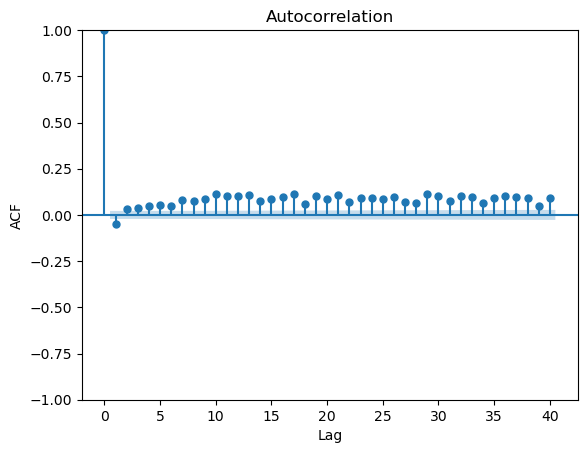

In [73]:
from statsmodels.graphics.tsaplots import plot_acf

fig_acf = plot_acf(ts['NumCPFCNPJ'], lags=40)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()


# https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html

# Se uma autocorrelação está fora do intervalo "mancha azul", significa que ela é significativamente diferente de zero e indica algum padrão na série.
# A autocorrelação no lag 1 é positiva e está fora do intervalo de desconfiança, o que significa que há uma relação significativa entre o valor atual da série e o valor anterior. Isso pode indicar que a série tem algum componente autoregressivo (AR), ou seja, que depende dos seus próprios valores passados.
# As autocorrelações nos demais lags são próximas de zero e estão dentro do intervalo de confiança, o que significa que não há relações significativas entre o valor atual da série e os valores mais distantes no tempo. Isso pode indicar que a série não tem nenhum componente de média móvel (MA), ou seja, que não depende dos erros passados.

#### 2.2.9 - PACF (autocorrelação parcial)

A autocorrelação parcial é útil para identificar os termos autoregressivos (AR) em um modelo ARIMA. Se a autocorrelação parcial é significativa em um determinado lag, isso significa que há uma relação direta entre a observação atual e a observação nesse lag. O número de lags significativos indica a ordem do termo AR.

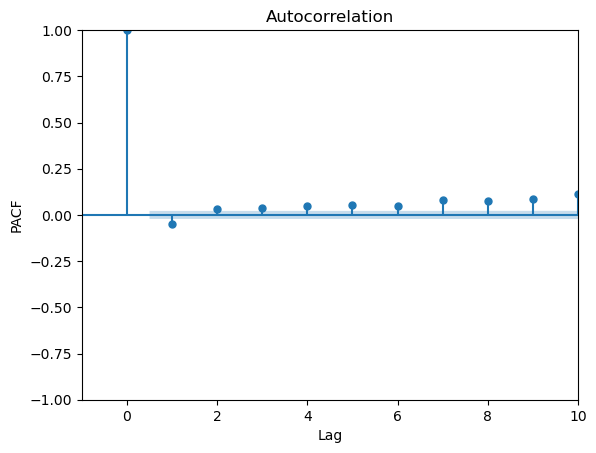

In [15]:
plot_acf(ts['NumCPFCNPJ'], lags=10, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.xlim([-1, 10])
plt.show()

# lag 0 é igual a 1, o que é esperado, pois significa que a série está correlacionada consigo mesma.

### 2.3 - Análises de interesse:


##### Análises da potencia instalada por tempo, segmentado por: 
        - SigTipoConsumigor (pf/pj) e SigUF(uf)
        - 

##### Análises o agente instalada por grupo tarifario, segmentado por: 
        - SigTipoConsumigor (pf/pj) e SigUF(uf)
        - 


##### Colunas adequadas para utilização: 

        - SigUF - nome do estado do empreendimento
        - NomMunicipio - nome do município do empreendimento

        - SigTipoConsumidor (PF ou PJ)
        - DthAtualizaCadastralEmpreend

        - DscClasseConsumo - descrição da classe de consumo do empreendimento
        - CodSubGrupoTarifario - código do subgrupo tarifário do empreendimento

        - DscFonteGeracao - descrição da fonte de geração do empreendimento

        - NomAgente - nome do agente 
        - DscPorte - descrição do porte do agente
        - MdaPotenciaInstaladaKW - potência instalada do agente em kW

##### Evoluções do número de usuários por tempo, segmentado por: 

        - SigTipoConsumigor (pf/pj) e SigUF(uf)
        - DscClasseConsumo (resid/comercial/industrial) e SigUF(uf)


In [19]:
counts = df_clean.groupby(['Ano_Mes', 'SigUF','SigTipoConsumidor', 'DscClasseConsumo']).agg({'NumCPFCNPJ': 'nunique'}).reset_index()


In [21]:
import matplotlib.pyplot as plt
# agrupa os dados
counts = df_clean.groupby(['Ano_Mes', 'SigUF','SigTipoConsumidor', 'DscClasseConsumo']).agg({'NumCPFCNPJ': 'nunique'}).reset_index()
# seria bom adicionar uma linha com a taxa de crescimento anual por Tipo de Consumidor
def grafico_fig_3(counts):
    #counts_filtered = counts.query('Ano_Mes >= 2023-03')
    fig_3 = px.bar(counts, x="Ano_Mes", y="NumCPFCNPJ", color='SigTipoConsumidor')
    fig_3.update_layout(
        width=1200,
        height=600,
        xaxis_title='Ano_Mes',
        xaxis_title_font_size=16,
        yaxis_title='Novos usuários',
        yaxis_title_font_size=16,
        title='Novos usuários por tipo de consumo',
        title_font_size=20,
        title_x=.5
    )
    fig_3.show()
grafico_fig_3(counts)

# Tornar a o eixo y variável pelo max de cada UF
def grafico_novos_usuarios_tipo_UF(counts):
    #counts_filtered = counts.query('Ano_Mes >= 2023-03')
    fig_novos_tipo_uf = px.bar(counts, x="Ano_Mes", y="NumCPFCNPJ", color='SigTipoConsumidor',barmode="group", facet_row="SigUF")
    fig_novos_tipo_uf.update_layout(
        width=1200,
        height=600,
        xaxis_title='Tempo',
        yaxis_title='Novos usuários',
        title={
        'text': "Novos usuários",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
        )

    fig_novos_tipo_uf.show()
    
grafico_novos_usuarios_tipo_UF(counts)



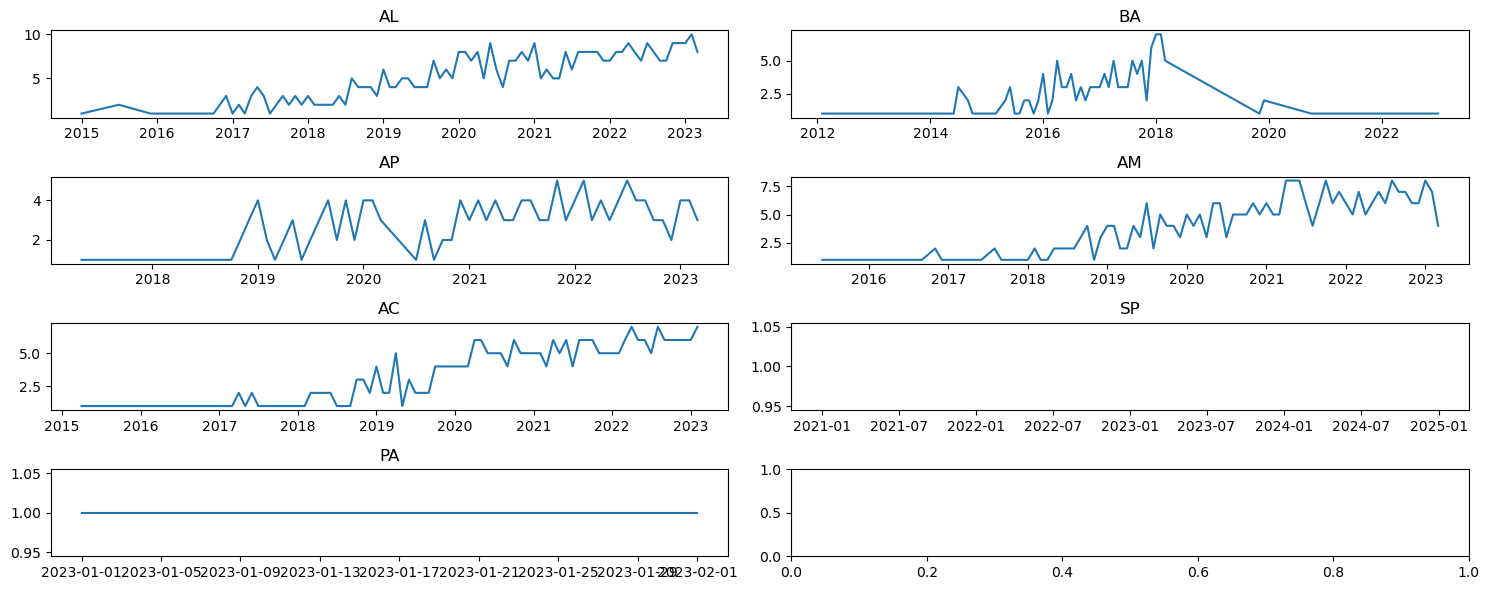

In [22]:
counts = df_clean.groupby(['Ano_Mes', 'SigUF','SigTipoConsumidor', 'DscClasseConsumo']).agg({'NumCPFCNPJ': 'nunique'}).reset_index()
counts_group = counts.groupby(['Ano_Mes','SigUF']).count().reset_index().sort_values(by='Ano_Mes')
counts_group['SigUF'].unique()

def gerar_grafico_Novos_estado(uf):
    counts_pivot = counts_group[counts_group['SigUF'] == uf].pivot(
    index='Ano_Mes', columns=['SigUF'], values='NumCPFCNPJ').fillna(0)
    counts_pivot.index = pd.to_datetime(counts_pivot.index)
    counts_pivot = counts_pivot.sort_index()
    return counts_pivot

# Criar uma figura com 2 linhas e 2 colunas de subplots
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 6))

# Plotar o primeiro gráfico no primeiro subplot
axs[0, 0].plot(gerar_grafico_Novos_estado('AL'))
axs[0, 0].set_title('AL')

# Plotar o segundo gráfico no segundo subplot
axs[0, 1].plot(gerar_grafico_Novos_estado('BA'))
axs[0, 1].set_title('BA')

# Plotar o terceiro gráfico no terceiro subplot
axs[1, 0].plot(gerar_grafico_Novos_estado('AP'))
axs[1, 0].set_title('AP')

# Plotar o quarto gráfico no quarto subplot
axs[1, 1].plot(gerar_grafico_Novos_estado('AM'))
axs[1, 1].set_title('AM')

axs[2, 0].plot(gerar_grafico_Novos_estado('AC'))
axs[2, 0].set_title('AC')

axs[2, 1].plot(gerar_grafico_Novos_estado('SP'))
axs[2, 1].set_title('SP')

axs[3, 0].plot(gerar_grafico_Novos_estado('PA'))
axs[3, 0].set_title('PA')

# Ajustar a distância entre os subplots
fig.tight_layout()

# Mostrar a figura
plt.show()

In [44]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Criar subplots
fig_nusuarios_uf = make_subplots(rows=4, cols=2, subplot_titles=['AL', 'BA', 'AP', 'AM', 'AC', 'SP', 'PA'])

# Adicionar gráficos a cada subplot
fig_nusuarios_uf.add_trace(
    go.Scatter(x=gerar_grafico_Novos_estado('AL').index, y=gerar_grafico_Novos_estado('AL').values.flatten(), mode='lines'),
    row=1, col=1
)

fig_nusuarios_uf.add_trace(
    go.Scatter(x=gerar_grafico_Novos_estado('BA').index, y=gerar_grafico_Novos_estado('BA').values.flatten(), mode='lines'),
    row=1, col=2
)

fig_nusuarios_uf.add_trace(
    go.Scatter(x=gerar_grafico_Novos_estado('AP').index, y=gerar_grafico_Novos_estado('AP').values.flatten(), mode='lines'),
    row=2, col=1
)

fig_nusuarios_uf.add_trace(
    go.Scatter(x=gerar_grafico_Novos_estado('AM').index, y=gerar_grafico_Novos_estado('AM').values.flatten(), mode='lines'),
    row=2, col=2
)

fig_nusuarios_uf.add_trace(
    go.Scatter(x=gerar_grafico_Novos_estado('AC').index, y=gerar_grafico_Novos_estado('AC').values.flatten(), mode='lines'),
    row=3, col=1
)

fig_nusuarios_uf.add_trace(
    go.Scatter(x=gerar_grafico_Novos_estado('SP').index, y=gerar_grafico_Novos_estado('SP').values.flatten(), mode='lines'),
    row=3, col=2
)

fig_nusuarios_uf.add_trace(
    go.Scatter(x=gerar_grafico_Novos_estado('PA').index, y=gerar_grafico_Novos_estado('PA').values.flatten(), mode='lines'),
    row=4, col=1
)

# Ajustar layout
fig_nusuarios_uf.update_layout(height=800, width=1000, title_text="Novos Usuários por UF")

# Exibir figura
fig_nusuarios_uf.show()


In [29]:
def grafico_novos_usuarios_classe(counts):
    fig_novos_classe = px.bar(counts, x="Ano_Mes", y="NumCPFCNPJ", color='DscClasseConsumo')
    fig_novos_classe.update_layout(
        width=1200,
        height=600,
        xaxis_title='Ano_Mes',
        xaxis_title_font_size=16,
        yaxis_title='Novos usuários',
        yaxis_title_font_size=16,
        title='Novos usuários por tipo de consumo',
        title_font_size=20,
        title_x=.5
    )
    fig_novos_classe.show()
grafico_novos_usuarios_classe(counts)


def grafico_novos_usuarios_classe_UF(counts):
    #counts_filtered = counts.query('Ano >= 2018')
    fig_novos_classe_uf = px.bar(counts, x="Ano_Mes", y="NumCPFCNPJ", color='DscClasseConsumo',barmode="group", facet_row="SigUF")
    fig_novos_classe_uf.update_layout(
        width=800,
        height=600,
        title={
        'text': "Novos usuários",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
        )
    fig_novos_classe_uf.show()
grafico_novos_usuarios_classe_UF(counts)


##### #_____________________GRÁFICOS DO app.py, MUITO CUIDADO!____________________#

In [30]:
# O gráfico 1 mostra a evolução temporal do Total Mensal de Empreendimentos por Estado e por Classe de Consumo;

    # OBS1: estados com menos de 10 empreendimentos foram excluídos do gráfico;
    # OBS2: os dados de 2023 representam um corte até hoje


# agrupa os dados
counts = df_clean.groupby(['Ano_Mes', 'SigUF', 'DscClasseConsumo']).agg({'NumCPFCNPJ': 'nunique'}).reset_index()

# Cria uma lista com as opções de SigUF para dropdown
sigufs = df_clean['SigUF'].unique()

# cria o gráfico de áreas empilhadas

fig_3 = px.bar(counts, x="Ano_Mes", y="NumCPFCNPJ", color="DscClasseConsumo", title="Novos usuários da rede distribuida")

# estilo do grafico
fig_3.update_layout(
    width=1200,
    height=600,
    xaxis_title='Ano_Mes',
    xaxis_title_font_size=16,
    xaxis_tickfont_size=14,
    yaxis_title='NumCPFCNPJ',
    yaxis_title_font_size=16,
    yaxis_tickfont_size=14,
    title='Novos usuários da Energia distribuida',
    title_font_size=20,
    title_x=.5,
    margin=dict(t=130)
)


fig_3.update_yaxes(range=[0, 6000])

In [32]:


df['Mes'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).month
df['Ano'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).year

counts = df_clean.groupby(['Ano', 'SigUF', 'DscClasseConsumo']).agg({'NumCPFCNPJ': 'nunique'}).reset_index()
tabela = counts.groupby(['Ano', 'SigUF'])['NumCPFCNPJ'].sum().reset_index()

matriz = tabela.pivot(index='SigUF', columns='Ano', values='NumCPFCNPJ')
matriz = matriz.fillna(0)
matriz.loc['BR'] = matriz.sum()

matriz_tx = matriz.pct_change(axis=1) * 100
matriz_tx = matriz_tx.applymap(lambda x: '{:.0f}%'.format(x) if not np.isnan(x) and x != 0 else ' ')
matriz_tx['med'] = ""
matriz_tx['Total'] = ""
matriz_tx['2023'] = ""





import plotly.graph_objs as go
import plotly.figure_factory as ff
import numpy as np

# Criando uma lista de strings com valores da matriz e matriz_tx
text = [[f"{matriz.iloc[i,j]:}<br>{matriz_tx.iloc[i,j]}" for j in range(len(matriz.columns))] for i in range(len(matriz.index))]
# Criação do heatmap principal
fig_2 = ff.create_annotated_heatmap(z=matriz.values,
                                  x=list(matriz.columns),
                                  y=list(matriz.index),
                                  annotation_text=text,
                                  font_colors=['gray', 'white'],
                                  colorscale='YlGnBu')
# Configurações de layout
fig_2.update_layout(
    width=1200,
    height=600,
    xaxis_title='Ano',
    xaxis_title_font_size=16,
    xaxis_tickfont_size=14,
    yaxis_title='SigUF',
    yaxis_title_font_size=16,
    yaxis_tickfont_size=14,
    title='Novos usuários da Energia distribuida',
    title_font_size=20,
    title_x=.5,
    margin=dict(t=130)
)    

fig_2.show()



#### Modelo prophet


Apesar dos dados serem não estacionários a aplicação do modelo prophet apresentou R²=0.77, ajustarei parametros para obter previsões mais assertivas


com aplicação em dados diários

- MSE: 111.00
    O MSE indica o quão próximo as previsões estão dos valores reais, sendo que um valor mais próximo de zero indica melhor desempenho do modelo. No caso, o valor de 111.00 indica que as previsões estão relativamente próximas dos valores reais.

- MAE: 6.73
    O MAE também é uma medida de erro e indica a diferença média absoluta entre as previsões e os valores reais. Um valor menor indica que o modelo tem menor erro médio absoluto nas previsões.

- R2 Score: 0.77
    O R2 Score é uma medida de quão bem o modelo explica a variação dos dados. Ele varia de 0 a 1, sendo que valores mais próximos de 1 indicam que o modelo é capaz de explicar melhor a variação dos dados. No caso, o valor de 0.77 indica que o modelo consegue explicar razoavelmente bem a variação dos dados.

- aplicação em dados mesnais
MSE: 1709.98
MAE: 37.92
R2 Score: -10.21

In [39]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import datetime
import warnings
warnings.filterwarnings('ignore')

ts_clean = ts.drop(['SigUF', 'SigTipoConsumidor','DscClasseConsumo'], axis=1)
ts_clean = ts_clean.groupby('DthAtualizaCadastralEmpreend').sum()


def prever_prophet(df_prophet):
    # Criando tabelas para o modelo
    df_prophet = ts_clean.copy()
    df_prophet = df_prophet.reset_index()
    df_prophet = df_prophet.rename(columns={'DthAtualizaCadastralEmpreend': 'ds', 'NumCPFCNPJ': 'y'})     # modelo pede colunas "ds" e "y"

    # cria o objeto Prophet e ajusta ao dataframe
    modelo = Prophet()
    modelo.fit(df_prophet)

    # define o período de previsão (1 ano)
    futuro = modelo.make_future_dataframe(periods=12*1, freq='M')
    previsao = modelo.predict(futuro)
    return previsao
prever_prophet(df_prophet)

# plot dos resultados
def visualizar_prophet(modelo, previsao):
    fig, ax = plt.subplots(figsize=(12, 4))
    modelo.plot(previsao, ax=ax)
    ax.set_xlabel('Data', fontsize=12)
    ax.set_ylabel('Novos usuários', fontsize=12)
    ax.set_title('Previsão de novos usuários BR', fontsize=14)
    ax.set_facecolor('#f5f5f5')
    ax.grid(color='white', alpha=0.5)
    ax.tick_params(axis='both', which='major', labelsize=10, color='grey')
    ax.legend(['Dados originais', 'Previsão'], prop={'size': 12})
    fig_comp = modelo.plot_components(previsao)
    plt.show()
visualizar_prophet(modelo, previsao)

# cálculo das métricas de avaliação do modelo

def avaliar_previsao(df_true, df_pred):
    y_true = df_true['y']
    y_pred = df_pred['yhat'][:len(y_true)]
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print('MSE: {:.2f}'.format(mse))
    print('MAE: {:.2f}'.format(mae))
    print('R2 Score: {:.2f}'.format(r2))
avaliar_previsao(df_prophet, previsao)

# Hiperparametros
#- *changepoint_prior_scale* controla a flexibilidade da curva de tendência. Valores menores deste parâmetro tornam a curva mais flexível, enquanto valores maiores a tornam mais rígida. É possível testar diferentes valores para encontrar o que melhor se ajusta aos dados.
#- *changepoint_range* define a porcentagem da série temporal em que são permitidos os pontos de mudança na tendência. Valores menores deste parâmetro restringem a possibilidade de mudanças na tendência a períodos mais curtos da série, enquanto valores maiores permitem que ocorram em períodos mais longos. Também é possível testar diferentes valores para encontrar o que melhor se ajusta aos dados.
#- *seasonality_mode* para ajustar o modelo considerando diferentes formas de sazonalidade, como aditiva ou multiplicativa, ou utilizar o parâmetro seasonality_prior_scale para controlar a flexibilidade da curva de sazonalidade.
#- *growth*: define o tipo de crescimento da série temporal. útil para séries que apresentam um limite superior, como a capacidade máxima de produção de energia de uma usina.
#- *changepoints*: permite especificar os pontos de mudança na série temporal onde a tendência pode sofrer uma alteração. Capturar mudanças abruptas na série

NameError: name 'df_prophet' is not defined

### 2.4 - Previsões Simples

#### Modelos de referência

#### Modelos Simples (AR e MM)

##### Modelo auro regressivo (AR)

In [65]:
ar = ts_clean.copy()
pd.DataFrame(ar)

# criando variáveis de treino e teste
t_treino = ar[ar.index < '2022-06-01'].index.values
t_teste = ar[ar.index >= '2022-06-01'].index.values
X_treino = ar[ar.index < '2022-06-01'].values
X_teste = ar[ar.index >= '2022-06-01'].values


from statsmodels.tsa.ar_model import AutoReg


#______________COEFICIENTES______________#
print('coefficients: %s' % resultado.params)
# o modelo tem dois coeficientes, um constante de 1,970 e um coeficiente de 0,493 que se refere à correlação da variável dependente com sua própria defasagem



#_________________MODELO_________________#
modelo = AutoReg(X_treino, 1)
resultado = modelo.fit()
print(resultado.summary())

# AIC = 4826.332 
# BIC = 4840.658,
# A raiz unitária está fora do intervalo de confiança, o que sugere que a série temporal é estacionária e não exige diferenciação.


# Log Likelihood (log-verossimilhança): quanto maior esse valor, melhor o modelo se ajusta aos dados observados;
# AIC (Akaike Information Criterion): uma medida que penaliza modelos com mais parâmetros e favorece modelos mais simples;
# BIC (Bayesian Information Criterion): semelhante ao AIC, mas com uma penalidade maior para modelos mais complexos;
# Coeficientes (coef): indicam a relação entre as variáveis dependentes e independentes. Se o coeficiente for positivo, significa que um aumento na variável independente leva a um aumento na variável dependente, e se for negativo, significa que um aumento na variável independente leva a uma diminuição na variável dependente.


coefficients: [ 0.34559465  0.18441216  0.013579    0.02239355 -0.00852994 -0.10440744
  0.34339338  0.15363519 -0.00760387  0.00213261 -0.0468925   0.00375359
 -0.02520875  0.10841967  0.10839345 -0.04518378  0.01141479  0.08280583
  0.09849766  0.07943918  0.01537154]
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1521
Model:                     AutoReg(1)   Log Likelihood               -5662.018
Method:               Conditional MLE   S.D. of innovations             10.035
Date:                Thu, 30 Mar 2023   AIC                          11330.035
Time:                        00:02:34   BIC                          11346.015
Sample:                             1   HQIC                         11335.984
                                 1521                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------

In [68]:
#_________________PREDIÇÃO_________________#
X_pred = resultado.predict(start=len(X_treino), end=len(X_treino)+len(X_teste)-1)


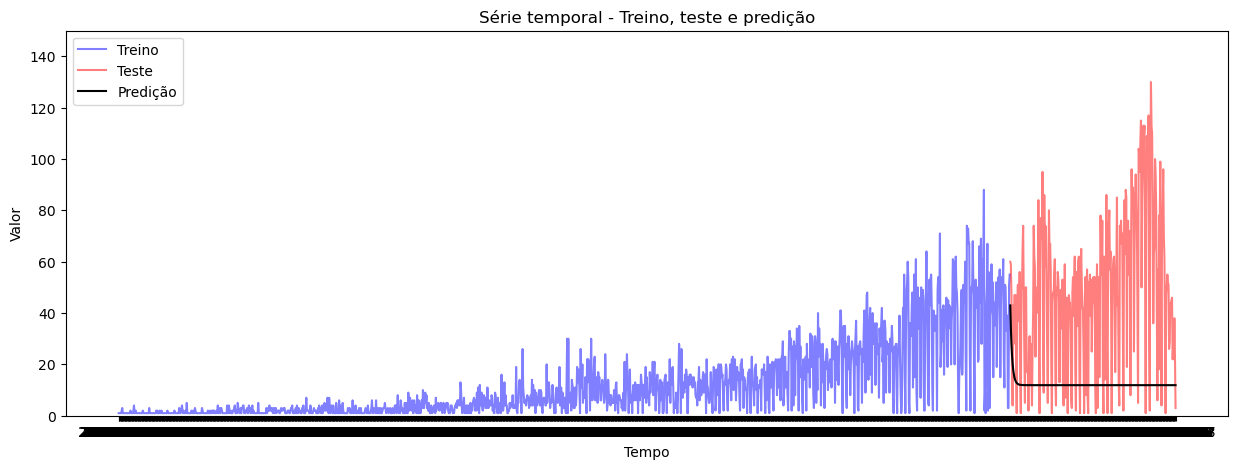

In [69]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(t_treino, X_treino, color='blue', alpha=0.5, label='Treino')
plt.plot(t_teste, X_teste, color='red', alpha=0.5, label='Teste')
plt.plot(t_teste, X_pred, color='black', label='Predição')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.title('Série temporal - Treino, teste e predição')
plt.legend()
plt.ylim(0, 150)
plt.show()

#o modelo não está sendo capaz de capturar as variações presentes nos dados.

In [70]:
#_________________ERRO_________________#


from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(X_teste, X_pred)
RMSE = np.sqrt(MSE)
print('RMSE: {:.2f}'.format(RMSE))
print('MSE: {:.2f}'.format(MSE))

# RMSE (Root Mean Squared Error) é uma medida de erro quadrático. Em média, os valores previstos estão a cerca de 46.19 unidades de distância dos valores observados.

# MSE (Mean Squared Error) é a média dos erros ao quadrado, o que pode ser útil para comparar diferentes modelos. A previsão está 2133.64 unidades de distância ao quadrado.

RMSE: 46.19
MSE: 2133.64


In [71]:
# Avaliar a performance do modelo e comparar diferentes modelos entre si.

for i in range (1,25):
    modelo = AutoReg(X_treino, i)
    resultado = modelo.fit()
    AIC = resultado.aic
    X_pred = resultado.predict(start=len(X_treino), end=len(X_treino)+len(X_teste)-1, dynamic=False)
    MSE = mean_squared_error(X_teste, X_pred)
    RMSE = np.sqrt(MSE)
    print("i = {} AIC = {:.2f} RMSE = {:.2f} MSE = {:.2f}".format(i, AIC, RMSE, MSE))


# AIC de menot valor é o 19

i = 1 AIC = 11330.04 RMSE = 46.19 MSE = 2133.64
i = 2 AIC = 11250.40 RMSE = 46.04 MSE = 2119.81
i = 3 AIC = 11180.84 RMSE = 45.89 MSE = 2105.86
i = 4 AIC = 11129.33 RMSE = 45.73 MSE = 2091.25
i = 5 AIC = 11065.61 RMSE = 45.38 MSE = 2059.67
i = 6 AIC = 10632.49 RMSE = 43.10 MSE = 1857.30
i = 7 AIC = 10545.91 RMSE = 41.06 MSE = 1685.63
i = 8 AIC = 10541.75 RMSE = 40.94 MSE = 1675.68
i = 9 AIC = 10537.69 RMSE = 41.03 MSE = 1683.21
i = 10 AIC = 10533.58 RMSE = 40.92 MSE = 1674.71
i = 11 AIC = 10520.44 RMSE = 40.08 MSE = 1606.54
i = 12 AIC = 10512.08 RMSE = 39.38 MSE = 1551.00
i = 13 AIC = 10473.73 RMSE = 37.21 MSE = 1384.26
i = 14 AIC = 10454.68 RMSE = 35.62 MSE = 1269.00
i = 15 AIC = 10448.86 RMSE = 36.18 MSE = 1308.68
i = 16 AIC = 10442.87 RMSE = 35.60 MSE = 1267.66
i = 17 AIC = 10422.00 RMSE = 34.14 MSE = 1165.82
i = 18 AIC = 10399.27 RMSE = 32.65 MSE = 1066.13
i = 19 AIC = 10385.66 RMSE = 31.75 MSE = 1008.18
i = 20 AIC = 10381.43 RMSE = 31.58 MSE = 997.27
i = 21 AIC = 10374.33 RMSE = 3

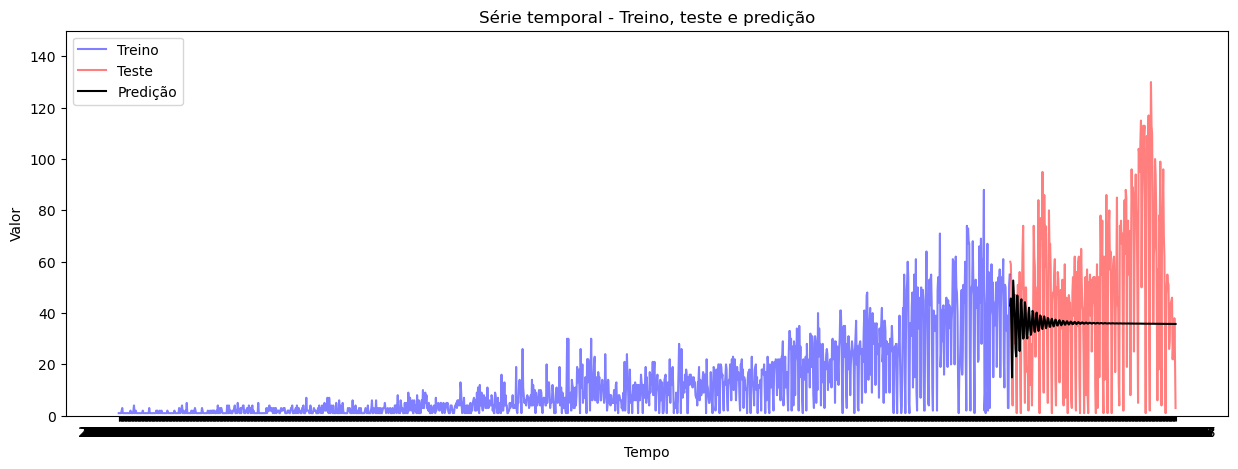

In [72]:
# lags define quantos períodos anteriores serão considerados na criação do modelo de previsão.

modelo = AutoReg(X_treino, lags=20)
resultado = modelo.fit()
X_pred = resultado.predict(start=len(X_treino), end=len(X_treino)+len(X_teste)-1)



fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(t_treino, X_treino, color='blue', alpha=0.5, label='Treino')
plt.plot(t_teste, X_teste, color='red', alpha=0.5, label='Teste')
plt.plot(t_teste, X_pred, color='black', label='Predição')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.title('Série temporal - Treino, teste e predição')
plt.legend()
plt.ylim(0, 150)
plt.show()

##### Média móvel

In [78]:
mm = ts_clean.copy()
pd.DataFrame(mm)

t_treino_mm = mm[mm.index < '2023-01-01'].index
t_teste_mm = mm[mm.index >= '2023-01-01'].index
X_treino_mm = mm[mm.index < '2023-01-01']
X_teste_mm = mm[mm.index >= '2023-01-01']


# calcula o número de previsões que serão feitas para os dados de teste.
forecast = len(X_teste_mm)

# cria um dataframe com os dados de teste e com a coluna de previsões zerada.
y_hat_avg = X_teste_mm.copy()

# cria uma coluna de previsões zerada.
y_hat_avg['predicao'] = 0
len(y_hat_avg['predicao'])


# faz um loop para preencher a coluna de previsões com a média móvel dos dados de treino.
for i in range(forecast):
    y_hat_avg['predicao'].iloc[i] = X_treino_mm['NumCPFCNPJ'].rolling(i).mean().iloc[-1]





# remove os valores nulos do dataframe.

#y_hat_avg = y_hat_avg.dropna()

len(y_hat_avg['predicao'])





t_treino_mm = t_treino_mm.values
X_treino_mm = X_treino_mm.values
X_teste_mm = X_teste_mm.values
t_teste_mm = t_teste_mm.values
X_pred_mm = y_hat_avg.values



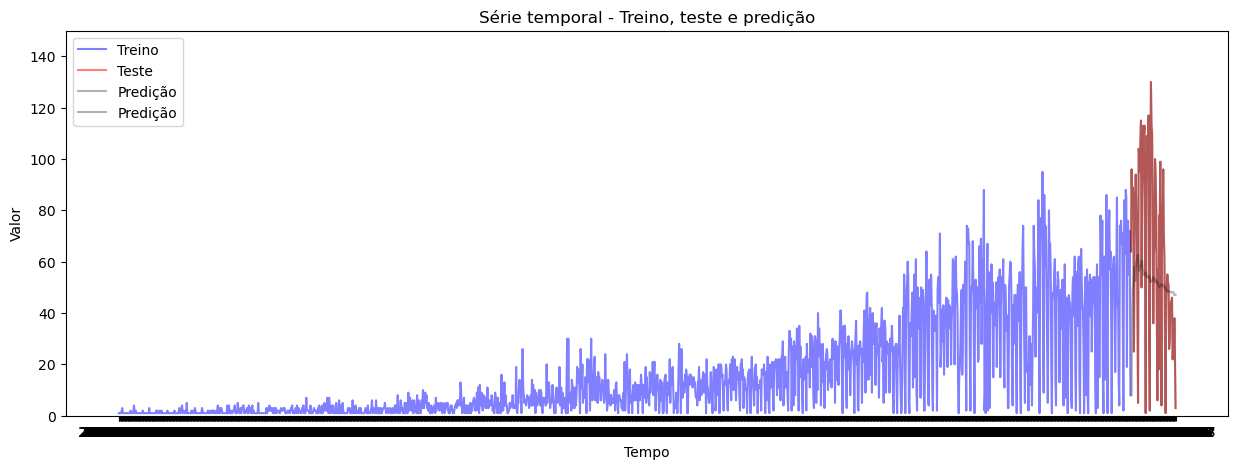

In [85]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(t_treino_mm,X_treino_mm, color='blue', alpha=0.5, label='Treino')
plt.plot(t_teste_mm,X_teste_mm, color='red', alpha=0.5, label='Teste')
plt.plot(t_teste_mm,X_pred_mm, color='black', label='Predição', alpha=0.3)
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.title('Série temporal - Treino, teste e predição')
plt.legend()
plt.ylim(0, 150)
plt.show()

In [83]:
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(X_teste_mm,y_hat_avg['predicao'])

RMSE = np.sqrt(MSE)

print("RMSE = {:0.2f}".format(RMSE))

ValueError: Input contains NaN.

### 2.5 - Previsões Complexas (prophet, ARIMA)

#### 2.5.1 - Prophet

##### Resutlados

    O MSE indica o quão próximo as previsões estão dos valores reais, sendo que um valor mais próximo de zero indica melhor desempenho do modelo. No caso, o valor de 111.00 indica que as previsões estão relativamente próximas dos valores reais.
    O MAE também é uma medida de erro e indica a diferença média absoluta entre as previsões e os valores reais. Um valor menor indica que o modelo tem menor erro médio absoluto nas previsões.
    O R2 Score é uma medida de quão bem o modelo explica a variação dos dados. Ele varia de 0 a 1, sendo que valores mais próximos de 1 indicam que o modelo é capaz de explicar melhor a variação dos dados. No caso, o valor de 0.77 indica que o modelo consegue explicar razoavelmente bem a variação dos dados.



##### Dados diários
        - MSE: 111.00: 
        - MAE: 6.73: 
        - R2 Score: 0.77: 

##### Dados mensais

        - MSE: 1709.98
        - MAE: 37.92
        - R2 Score: -10.21

In [85]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import datetime


def prever_prophet(df_prophet):
    # Criando tabelas para o modelo
    df_prophet = ts_clean.copy()
    df_prophet = df_prophet.reset_index()
    df_prophet = df_prophet.rename(columns={'DthAtualizaCadastralEmpreend': 'ds', 'NumCPFCNPJ': 'y'})     # modelo pede colunas "ds" e "y"

    # cria o objeto Prophet e ajusta ao dataframe
    modelo = Prophet()
    modelo.fit(df_prophet)

    # define o período de previsão (1 ano)
    futuro = modelo.make_future_dataframe(periods=12*1, freq='M')
    previsao = modelo.predict(futuro)
    return previsao
prever_prophet(df_prophet)

# plot dos resultados
def visualizar_prophet(modelo, previsao):
    fig, ax = plt.subplots(figsize=(12, 4))
    modelo.plot(previsao, ax=ax)
    ax.set_xlabel('Data', fontsize=12)
    ax.set_ylabel('Novos usuários', fontsize=12)
    ax.set_title('Previsão de novos usuários BR', fontsize=14)
    ax.set_facecolor('#f5f5f5')
    ax.grid(color='white', alpha=0.5)
    ax.tick_params(axis='both', which='major', labelsize=10, color='grey')
    ax.legend(['Dados originais', 'Previsão'], prop={'size': 12})
    fig_comp = modelo.plot_components(previsao)
    plt.show()
visualizar_prophet(modelo, previsao)

# cálculo das métricas de avaliação do modelo

def avaliar_previsao(df_true, df_pred):
    y_true = df_true['y']
    y_pred = df_pred['yhat'][:len(y_true)]
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print('MSE: {:.2f}'.format(mse))
    print('MAE: {:.2f}'.format(mae))
    print('R2 Score: {:.2f}'.format(r2))
avaliar_previsao(df_prophet, previsao)

# Hiperparametros
#- *changepoint_prior_scale* controla a flexibilidade da curva de tendência. Valores menores deste parâmetro tornam a curva mais flexível, enquanto valores maiores a tornam mais rígida. É possível testar diferentes valores para encontrar o que melhor se ajusta aos dados.
#- *changepoint_range* define a porcentagem da série temporal em que são permitidos os pontos de mudança na tendência. Valores menores deste parâmetro restringem a possibilidade de mudanças na tendência a períodos mais curtos da série, enquanto valores maiores permitem que ocorram em períodos mais longos. Também é possível testar diferentes valores para encontrar o que melhor se ajusta aos dados.
#- *seasonality_mode* para ajustar o modelo considerando diferentes formas de sazonalidade, como aditiva ou multiplicativa, ou utilizar o parâmetro seasonality_prior_scale para controlar a flexibilidade da curva de sazonalidade.
#- *growth*: define o tipo de crescimento da série temporal. útil para séries que apresentam um limite superior, como a capacidade máxima de produção de energia de uma usina.
#- *changepoints*: permite especificar os pontos de mudança na série temporal onde a tendência pode sofrer uma alteração. Capturar mudanças abruptas na série

NameError: name 'df_prophet' is not defined

#### 2.5.2 - ARMA

##### Como funciona


É representado por três parâmetros: (p, d, q). O parâmetro p é o número de termos AR que serão incluídos no modelo, o q é o número de termos MA e o d é o número de vezes que a série deve ser diferenciada para se tornar estacionária.


##### Resultados

In [382]:
df_arima

,NumCPFCNPJ
DthAtualizaCadastralEmpreend,
2012-02-03,1
2013-10-24,1
2014-02-05,1
2014-03-17,1
2014-06-05,1
...,...
2023-03-20,28
2023-03-21,22
2023-03-22,38


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Coeficients: [17.92161172  0.89199846  0.10774619 -0.65013909 -0.30269756 70.97763386]


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

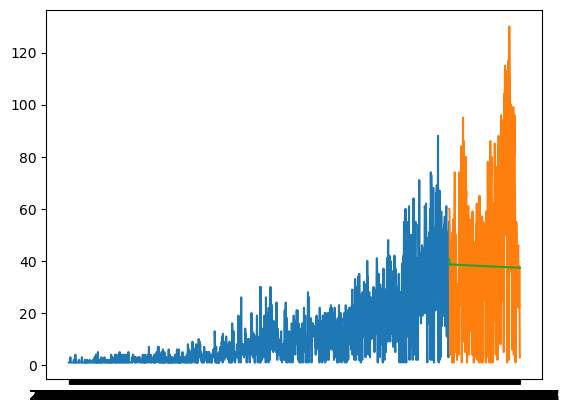

In [388]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# carregando o dataframe
df_arima = ts_clean.copy()

# Amostras de treino e teste
t_treino = df_arima[df_arima.index < '2022-06-01'].index.values
t_teste = df_arima[df_arima.index >= '2022-06-01'].index.values
X_treino = df_arima[df_arima.index < '2022-06-01'].values
X_teste = df_arima[df_arima.index >= '2022-06-01'].values

# definindo o modelo ARIMA
model = ARIMA(X_treino, order=(2, 0, 2))

# ajustando o modelo aos dados
resultado = model.fit()

print('Coeficients: %s' % resultado.params)
X_pred = resultado.predict(start=len(X_treino), end=len(X_treino)+len(X_teste)-1)

plt.plot(t_treino,X_treino)
plt.plot(t_teste,X_teste)
plt.plot(t_teste,X_pred)

In [389]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(X_teste,X_pred)
RMSE = np.sqrt(MSE)
print("RMSE = {:0.2f}".format(RMSE))


RMSE = 30.78


#### 2.5.3 - ARIMA

##### Como funciona

        AutoRegressão (AR): utiliza valores passados da própria série para fazer previsões futuras.
        Média Móvel (MA): utiliza erros passados da previsão para fazer previsões futuras.
        Integração (I): transforma a série em uma série estacionária, que é aquela em que a média e a variância não mudam com o tempo.

É representado por três parâmetros: (p, d, q). O parâmetro p é o número de termos AR que serão incluídos no modelo, o q é o número de termos MA e o d é o número de vezes que a série deve ser diferenciada para se tornar estacionária.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Cefficients: [17.92161172  0.89199846  0.10774619 -0.65013909 -0.30269756 70.97763386]


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

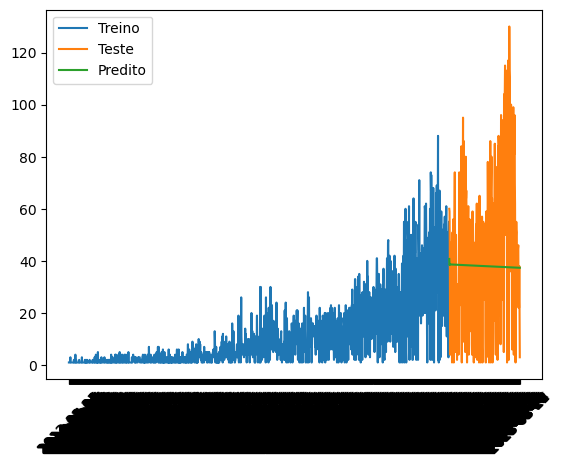

In [406]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# carregando o dataframe
df_arima = ts_clean.copy()

# Amostras de treino e teste
t_treino = df_arima[df_arima.index < '2022-06-01'].index.values
t_teste = df_arima[df_arima.index >= '2022-06-01'].index.values
X_treino = df_arima[df_arima.index < '2022-06-01'].values
X_teste = df_arima[df_arima.index >= '2022-06-01'].values


from statsmodels.tsa.api import ARIMA

model = ARIMA(X_treino, order= (2,0,2))
resultado = model.fit()

print("Cefficients: %s" % resultado.params)
X_pred = resultado.predict(start=len(X_treino), end=len(X_treino)+len(X_teste)-1)

plt.plot(t_treino,X_treino,label='Treino')
plt.plot(t_teste,X_teste,label='Teste')
plt.plot(t_teste,X_pred,label='Predito')
plt.xticks(rotation=45)
plt.legend()

In [404]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(X_teste,X_pred)
RMSE = np.sqrt(MSE)
print("RMSE = {:0.2f}".format(RMSE))

RMSE = 31.03


In [405]:
best = 1e6
i_best = 0
j_best = 0
k_best = 0

for i in range(1,4):
    for j in range(0,3):
        for k in range(0,2):
            modelo = ARIMA(X_treino, order=(i,k,j))
            resultado = modelo.fit()
            AIC = resultado.aic
            X_pred = resultado.predict(start=len(X_treino), end=len(X_treino)+len(X_teste)-1)
            MSE = mean_squared_error(X_teste,X_pred)
            RMSE = np.sqrt(MSE)
            if(RMSE<best):
                best = RMSE
                i_best = i
                j_best = j
                k_best = k
            print("i = {} j = {}, k={},  AIC = {:0.2f} RMSE = {:0.2f}".format(i,j,k,AIC,RMSE))
        
print("Melhor i = {}".format(i_best))
print("Melhor j = {}".format(j_best))
print("Melhor k = {}".format(k_best))

i = 1 j = 0, k=0,  AIC = 11337.78 RMSE = 46.23
i = 1 j = 0, k=1,  AIC = 11379.60 RMSE = 29.53
i = 1 j = 1, k=0,  AIC = 10873.84 RMSE = 30.90
i = 1 j = 1, k=1,  AIC = 10813.79 RMSE = 30.38
i = 1 j = 2, k=0,  AIC = 10815.25 RMSE = 30.76
i = 1 j = 2, k=1,  AIC = 10802.98 RMSE = 30.42
i = 2 j = 0, k=0,  AIC = 11264.70 RMSE = 46.10
i = 2 j = 0, k=1,  AIC = 11267.54 RMSE = 29.06
i = 2 j = 1, k=0,  AIC = 10826.41 RMSE = 30.74
i = 2 j = 1, k=1,  AIC = 10787.42 RMSE = 30.50
i = 2 j = 2, k=0,  AIC = 10815.50 RMSE = 30.78
i = 2 j = 2, k=1,  AIC = 10817.79 RMSE = 30.38
i = 3 j = 0, k=0,  AIC = 11201.62 RMSE = 46.08
i = 3 j = 0, k=1,  AIC = 11196.90 RMSE = 30.28
i = 3 j = 1, k=0,  AIC = 10800.05 RMSE = 30.88
i = 3 j = 1, k=1,  AIC = 10763.32 RMSE = 30.57
i = 3 j = 2, k=0,  AIC = 10829.55 RMSE = 30.71
i = 3 j = 2, k=1,  AIC = 10773.24 RMSE = 30.54
Melhor i = 2
Melhor j = 0
Melhor k = 1


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

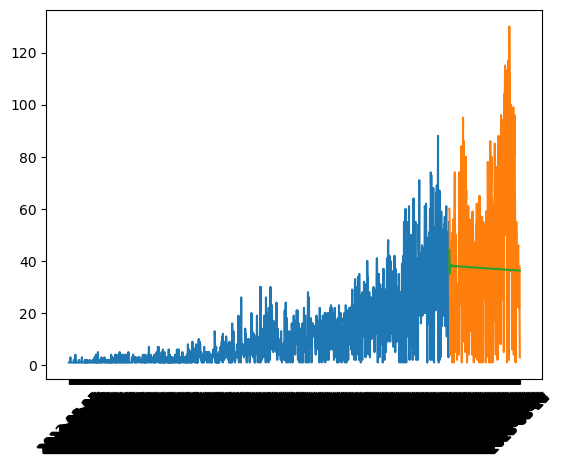

In [407]:
modelo = ARIMA(X_treino, order=(5,0,2))
resultado = modelo.fit()
X_pred = resultado.predict(start=len(X_treino), end=len(X_treino)+len(X_teste)-1)

plt.plot(t_treino,X_treino,label='Treino');
plt.plot(t_teste,X_teste,label='Teste');
plt.plot(t_teste,X_pred,label='Predito');
plt.xticks(rotation=45);

#### 2.5.4 - SARIMA

In [409]:

# sazonalidade ADF:
from statsmodels.tsa.stattools import adfuller

# Teste de ADF para verificar se há necessidade de diferenciação sazonal
result = adfuller(df_arima, maxlag=12)
print(f'ADF Estatística: {result[0]}')
print(f'p-valor: {result[1]}')
print('Valores críticos:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

if result[0] < result[4]['5%']:
    print('Rejeita H0 - Série é estacionária')
else:
    print('Falha em rejeitar H0 - Série é não estacionária')






# sazonalidade sazonal ADF:
from statsmodels.tsa.stattools import adfuller

# Teste de ADF sazonal para verificar se há necessidade de diferenciação sazonal
result = adfuller(df_arima, maxlag=12, autolag=None, regression='ct')
print(f'ADF Estatística: {result[0]}')
print(f'p-valor: {result[1]}')
print('Valores críticos:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

if result[0] < result[4]['5%']:
    print('Rejeita H0 - Série é sazonalmente estacionária')
else:
    print('Falha em rejeitar H0 - Série é sazonalmente não estacionária')


ADF Estatística: -2.082755652838002
p-valor: 0.25150493356181464
Valores críticos:
	1%: -3.434006447337251
	5%: -2.863155118104396
	10%: -2.567629837184558
Falha em rejeitar H0 - Série é não estacionária
ADF Estatística: -4.136041857896064
p-valor: 0.005580578031603556
Valores críticos:
	1%: -3.963833659698418
	5%: -3.4129441928372706
	10%: -3.128494890279243
Rejeita H0 - Série é sazonalmente estacionária
